In [35]:
!pip install tensorflow matplotlib numpy kaggle keras_preprocessing seaborn
!pip install -q kaggle
# !pip install tensorflow-metal

In [36]:
retrain = False

On commence par créer notre dataset d'entrainement (10 500 images, 70%) et notre dataset de test (4 500 images, 30%)
Le dataset contient 10 classes correspondantes à 10 plats de fast-food différents (burger, frites, donut, ...)

In [37]:
import os

try:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

except:
    print("Skipping google colab part")

import kaggle.api

if not os.path.exists('./fastfooddataset'):
    kaggle.api.authenticate() 
    kaggle.api.dataset_download_files('utkarshsaxenadn/fast-food-classification-dataset', path='./fastfooddataset', unzip=True)
else:
    print("dataset already downloaded")

Skipping google colab part
dataset already downloaded


In [38]:
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set the path to your dataset
dataset_path = './fastfooddataset/Fast Food Classification V2/Train'

# Define the image size and batch size
image_size = (200, 200)
batch_size = 50

train_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    validation_split=0.2,
    label_mode='categorical',
    subset="both",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True)

normalization_layer = tf.keras.layers.Rescaling(1./255)

class_names = train_dataset.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 10 classes.
Using 12000 files for training.
Using 3000 files for validation.
['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']


Affichage de quelques images

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10, 10))
try:
    for images, labels in train_dataset.take(1):
      for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
except:
    pass

2023-12-13 14:39:44.443825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 1000x1000 with 0 Axes>

In [40]:
import numpy as np

def train_model(model, n_epochs, model_name):
    model.compile(
        loss="categorical_crossentropy",
        optimizer='adam',
        metrics=["Accuracy", "F1Score", "AUC"],
    )
    
    model.build()
    print(model.summary())
    history = model.fit(train_dataset, epochs=n_epochs, validation_data=validation_dataset)
    model.save(f"/Users/timothee-l/Documents/CPE/5ETI/cpeMachineLearning/Projet/models/model_{model_name}")
    np.save(f'./history/history_{model_name}.npy',history.history)
    return history.history

In [41]:
def plot_history(history_dict):
    acc = history_dict['Accuracy']
    val_acc = history_dict['val_Accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    f1 = history_dict['f1_score']
    val_f1 = history_dict['val_f1_score']
    auc = history_dict['auc']
    val_auc = history_dict['val_auc']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim(0, 1)
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure(figsize=(12, 8))

    for i in range(len(class_names)):
        # Plot training F1-score with solid lines
        plt.plot(f1[i], label=f'Train - {class_names[i]}', linestyle='-', color=f'C{i}')
    
        # Plot validation F1-score with dotted lines
        plt.plot(val_f1[i], label=f'Val - {class_names[i]}', linestyle='--', color=f'C{i}')
    
    plt.title('F1-Score Training and Validation History for Each Class')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()
        
    plt.figure()
    
    plt.plot(epochs, auc, 'g', label='Training AUC')
    plt.plot(epochs, val_auc, 'b', label='Validation AUC')
    plt.ylim(0, 1)
    plt.title('Training and validation AUC')
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.show()

Dataset prediction/eval

In [42]:
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

data_dir = './fastfooddataset/Fast Food Classification V2/Valid'
batch_size = 32

data_generator = ImageDataGenerator(rescale=1./255)

prediction_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True)


Found 3500 files belonging to 10 classes.


In [69]:
for x,y in prediction_data:
    print(len(x))
    break

32


In [43]:
def evaluate_model(model):
    model.evaluate(prediction_data)

# Model 1: CNN Basique

In [44]:
cnn_classique = tf.keras.models.Sequential(
        [        
            tf.keras.layers.Rescaling(1./255, input_shape=(200, 200, 3)),
            tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ]
    )

if retrain:
    history_cnn_classique = train_model(cnn_classique, 10, "cnn_classique")
else:
    cnn_classique = tf.keras.models.load_model("./models/model_cnn_classique")
    history_cnn_classique = np.load('./history/history_cnn_classique.npy',allow_pickle='TRUE').item()

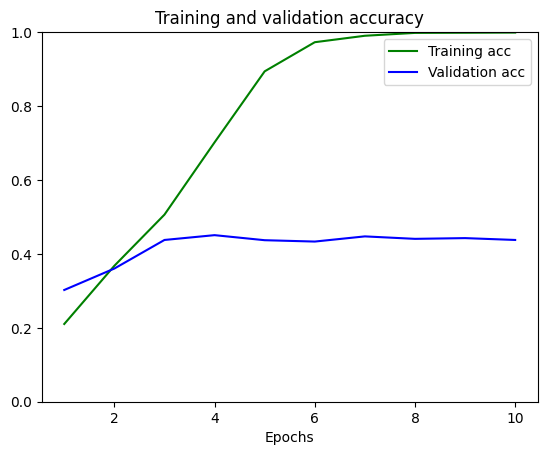

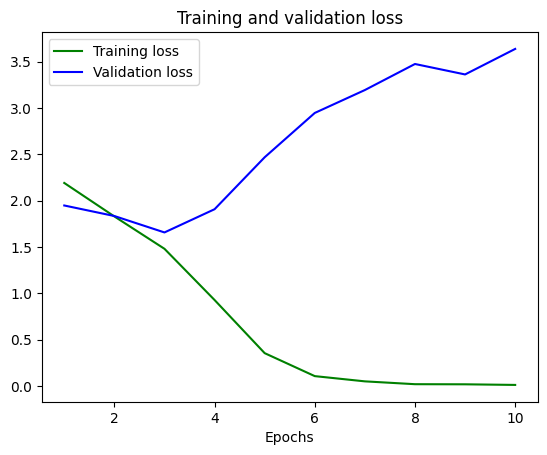

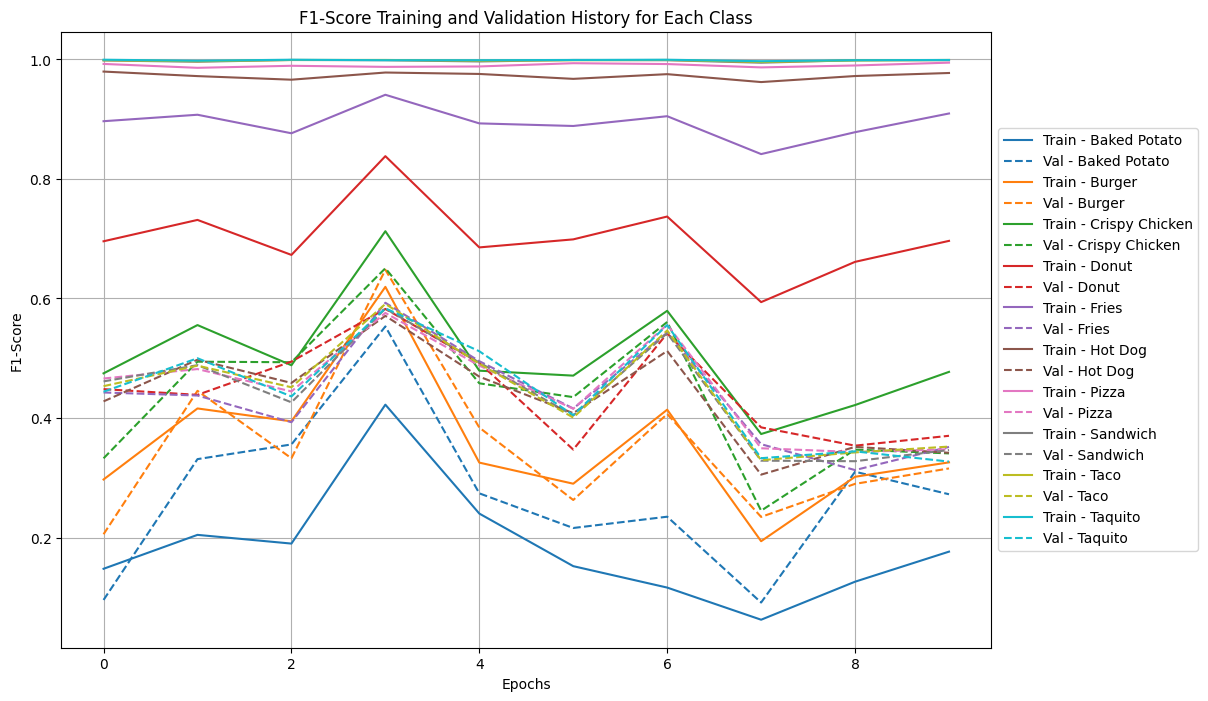

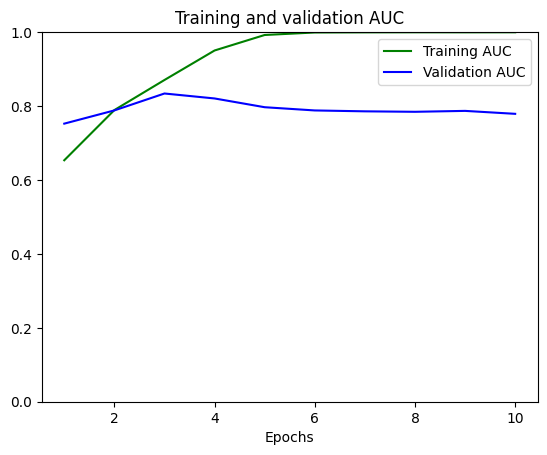

In [45]:
plot_history(history_cnn_classique)

In [46]:
evaluate_model(cnn_classique)

110/110 [==============================] - 15s 129ms/step - loss: 3.8814 - Accuracy: 0.4343 - f1_score: 0.4376 - auc: 0.7712


# Model 2: Augmented + Dropout

In [47]:
data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
cnn_augmented = tf.keras.models.Sequential(
    [        
        tf.keras.layers.Rescaling(1./255, input_shape=(200, 200, 3)),
        data_augmentation,
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
    ]
)
if retrain:
    history_cnn_augmented = train_model(cnn_augmented, 20, "cnn_augmented")
else:
    cnn_augmented = tf.keras.models.load_model("./models/model_cnn_augmented")
    history_cnn_augmented = np.load('./history/history_cnn_augmented.npy',allow_pickle='TRUE').item()

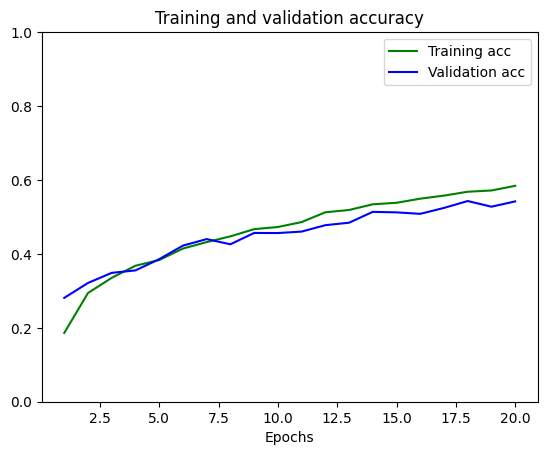

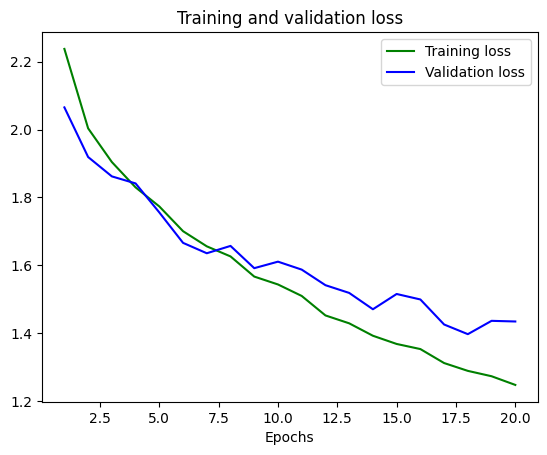

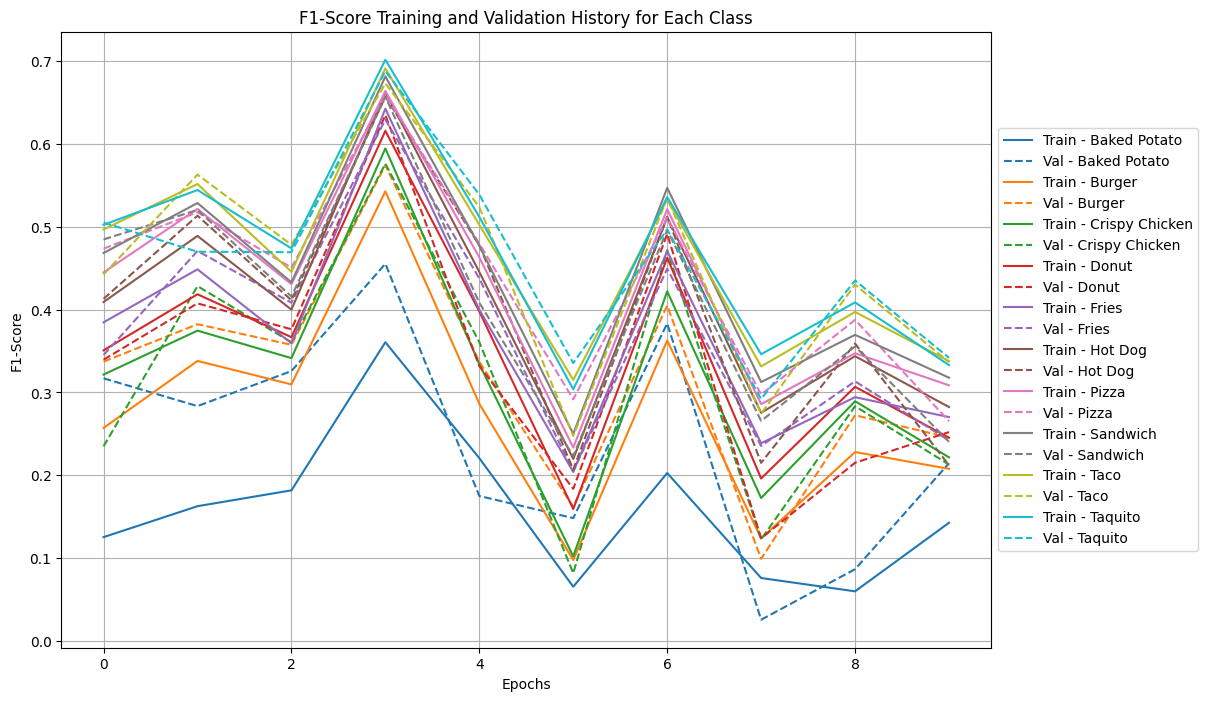

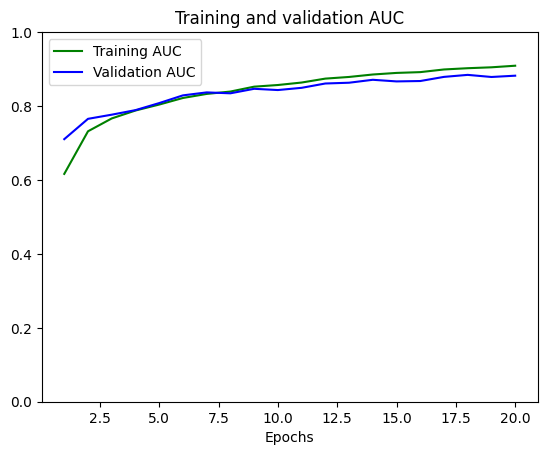

In [48]:
plot_history(history_cnn_augmented)

In [49]:
evaluate_model(cnn_augmented)

110/110 [==============================] - 14s 126ms/step - loss: 1.3799 - Accuracy: 0.5474 - f1_score: 0.5399 - auc: 0.8906


In [75]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def analyze_prediction(model):
    prediction = model.predict(prediction_data)
    predicted_labels = np.argmax(prediction, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Accuracy: {accuracy}")
    print(classification_report(true_labels, predicted_labels))
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [76]:
analyze_prediction(cnn_classique)

ValueError: in user code:

    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_5" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 200, 200, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 10) dtype=float32>]


110/110 [==============================] - 13s 119ms/step
Accuracy: 0.10342857142857143
              precision    recall  f1-score   support

           0       0.14      0.09      0.11       400
           1       0.09      0.08      0.09       300
           2       0.14      0.10      0.11       400
           3       0.09      0.14      0.11       300
           4       0.10      0.07      0.08       400
           5       0.07      0.10      0.08       300
           6       0.11      0.10      0.10       300
           7       0.08      0.08      0.08       300
           8       0.11      0.11      0.11       400
           9       0.12      0.17      0.14       400

    accuracy                           0.10      3500
   macro avg       0.10      0.10      0.10      3500
weighted avg       0.11      0.10      0.10      3500


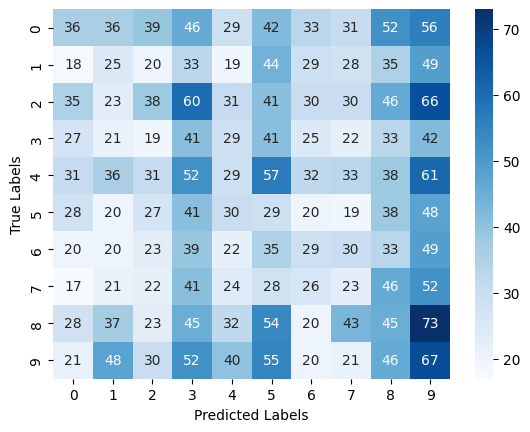

In [52]:
analyze_prediction(cnn_augmented)

In [66]:
prediction_data.take(1)

In [53]:
predictions_cnn_augmented = cnn_augmented.predict(prediction_data)

analyze_prediction(predictions_cnn_augmented)

# En utilisant un modèle pré-entrainé: Inception V3

In [54]:
!curl -o ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.8M  100 83.8M    0     0  22.5M      0  0:00:03  0:00:03 --:--:-- 22.5M  0:05:20  270k


In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(200, 200, 3), include_top=False, weights=None, classes=10) # Does not include classification layer
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [83]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(10, activation='softmax')(x)

# Configure and compile the model
inception = Model(pre_trained_model.input, x)
inception.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["Accuracy", "F1Score", "AUC"])


last layer output shape: (None, 10, 10, 768)


TypeError: ('Keyword argument not understood:', 'input_shape')

In [71]:
evaluate_model(inception)

110/110 [==============================] - 110s 982ms/step - loss: 30.7025 - Accuracy: 0.0897 - f1_score: 0.0464 - auc: 0.4944


In [58]:
predictions_inception = inception.predict(prediction_data)

110/110 [==============================] - 108s 976ms/step


Accuracy: 0.08514285714285715
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       400
           1       0.09      0.46      0.15       300
           2       0.00      0.00      0.00       400
           3       0.07      0.03      0.05       300
           4       0.21      0.01      0.02       400
           5       0.08      0.22      0.12       300
           6       0.00      0.00      0.00       300
           7       0.08      0.09      0.08       300
           8       0.11      0.05      0.07       400
           9       0.03      0.01      0.01       400

    accuracy                           0.09      3500
   macro avg       0.08      0.09      0.06      3500
weighted avg       0.08      0.09      0.05      3500


/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/timothee-l/miniconda3/envs/condaML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

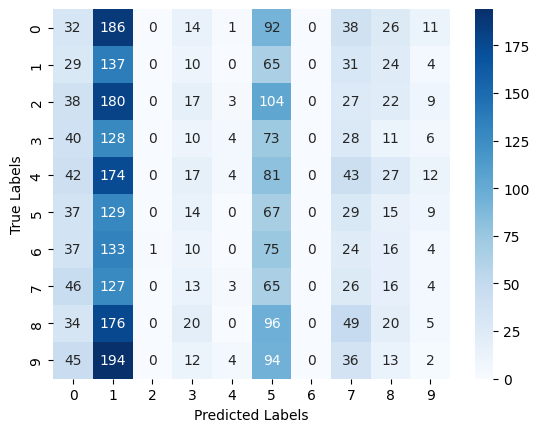

In [59]:
analyze_prediction(predictions_inception)